### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np

from mynn.neural_network import NeuralNetwork
from mynn.layers import Layer
from unsupervised_learning.algorithms import MountainClustering, FuzzCMeans
from anfis.anfis import ANFIS
from anfis.membership.membershipfunction import MemFuncs

from mynn.utils import train_model
from helper_functions.data_management import data_loading, joint_random_sampling
from helper_functions.plotting import plot_training_history, color_plot, plot3d_dataset, plot_embedding

### Auxiliary Functions

In [2]:
def create_autoencoder(num_features: int, num_hidden_units: int, learning_rate: float):

    autoenconder = NeuralNetwork(
        layers=[
            Layer(num_features, num_hidden_units, activation="sigmoid", include_bias=True),
            Layer(num_hidden_units, num_features, activation="sigmoid", include_bias=True),
        ],
        learning_rate=learning_rate,
        loss="cuadratic",
    )

    return autoenconder

def get_autoencoder_embedding(trained_autoencoder: NeuralNetwork, inputs: np.ndarray):

    autoencoder_layers = trained_autoencoder.layers
    encoding_layer = autoencoder_layers[0]

    return encoding_layer.forward(inputs)

def get_mountain_membership_function(centers, destructive_parameter):

    membership_function = []
    for cluster_dimension in centers.T:
        dim_membership_function = []
        for cluster_mean in cluster_dimension:
            dim_membership_function.append(["gaussmf", {"mean": cluster_mean, "sigma": destructive_parameter}])
        membership_function.append(dim_membership_function)

    return membership_function

def get_fuzzy_membership_function(centers, sigmas):

    membership_function = []
    for cluster_dimension in centers.T:
        dim_membership_function = []
        for cluster_num, cluster_mean in enumerate(cluster_dimension):
            dim_membership_function.append(["gaussmf", {"mean": cluster_mean, "sigma": sigmas[cluster_num]}])
        membership_function.append(dim_membership_function)

    return membership_function

### Data loading

In [3]:
manip_category = 'pump_and_dump'
energy_threshold = 0.5
use_cone = False
root_folder_path = os.path.dirname(os.getcwd())

manip_features = data_loading(root_folder_path, manip_category, energy_threshold, use_cone)

### Visualization

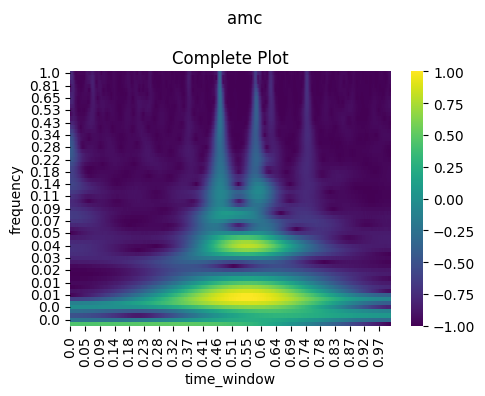

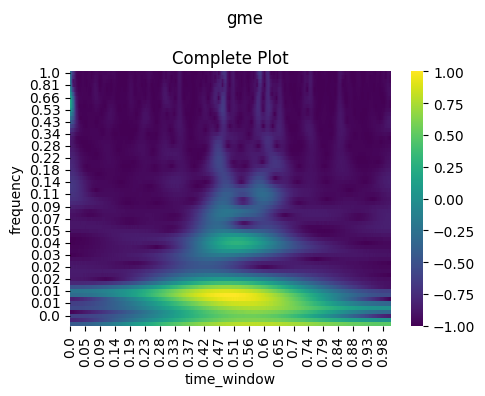

In [4]:
for stock_name, stock_dict in manip_features.items():
    color_plot(stock_dict, stock_name)

### 3d Visualization

In [6]:
stock_name = 'gme'
plot_against = 'frequency'
hue_var = 'target'
feature_matrix = manip_features[stock_name]['features']

plot3d_dataset(feature_matrix, stock_name, plot_against, hue_var)

### Train autoencoder and get embedding

Epoch 1/3 | Loss: 0.00139596529892736
Epoch 2/3 | Loss: 0.0012522028206480738
Epoch 3/3 | Loss: 0.0012394299043105173


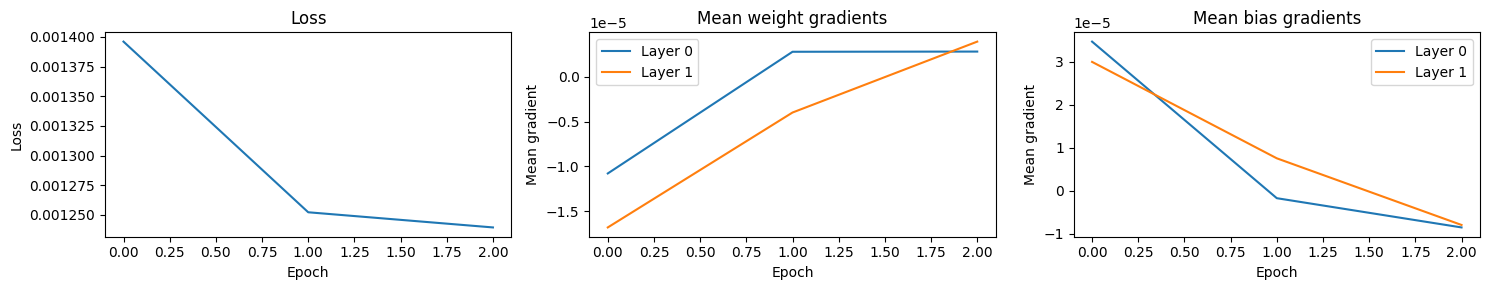

In [7]:
feature_matrices = [
    stock_dict['features'][:, :-2]
    for _, stock_dict in manip_features.items()
]

stacked_feature_matrix = np.vstack(feature_matrices)

autoencoder = create_autoencoder(num_features=stacked_feature_matrix.shape[1], num_hidden_units=2, learning_rate=1)

trained_autoencoder, train_history, _, _ = train_model(
    autoencoder, stacked_feature_matrix, stacked_feature_matrix, num_epochs=3, batch_size=1, verbose=True
)

plot_training_history(train_history, True, stacked_feature_matrix.shape[0])

### Sampling

In [8]:
percentage_to_sample = 5000 / stacked_feature_matrix.shape[0]
train_x_all, train_y, val_x_all, val_y, test_x_all, test_y = joint_random_sampling(manip_features, percentage_to_sample, 0.5, 'uniform', False)

train_x = train_x_all[:, :-1]
train_modulus = train_x_all[:, -1]
val_x = val_x_all[:, :-1]
val_modulus = val_x_all[:, -1]
test_x = test_x_all[:, :-1]
test_modulus = test_x_all[:, -1]

### Plot 3d results of sampled dataset

In [9]:
plot_against = 'frequency'
hue_var = 'modulus'

plot3d_dataset(np.concatenate([train_x_all, train_y.reshape(-1, 1)], axis=1),
                f'{manip_category} - Sampled Dataset',
                plot_against,
                hue_var)

### Get embeddings

In [10]:
train_embedding = get_autoencoder_embedding(trained_autoencoder, train_x.T).T
val_embedding = get_autoencoder_embedding(trained_autoencoder, val_x.T).T
test_embedding = get_autoencoder_embedding(trained_autoencoder, test_x.T).T

### Plot embeddings

In [11]:
plot_embedding(np.hstack([train_embedding, train_modulus.reshape(-1, 1), train_y.reshape(-1, 1)]),
                f'{manip_category} - Embedding Sampled Dataset',
                hue_modulus=True)

### ANFIS

#### Mountain Clustering

In [13]:
sigma_squared = 1.1
beta_squared = sigma_squared*1.5
mountain_clustering = MountainClustering(number_of_partitions=50,
                                        distance_metric='euclidean',
                                        sigma_squared=sigma_squared,
                                        beta_squared=beta_squared,)

mountain_clustering.fit(train_embedding)

MountainClustering(beta_squared=1.6500000000000001, number_of_partitions=50,
                   sigma_squared=1.1)

##### ANFIS fitting and prediction

In [14]:
# Get unique centers
mountain_centers = np.unique(mountain_clustering.centers_, axis=0)

# Get membership functions
fuzzy_membership_function = MemFuncs(get_mountain_membership_function(mountain_centers, beta_squared))

# Instance anfis object and train it
mountain_anfis = ANFIS(train_embedding, train_modulus, fuzzy_membership_function)
mountain_x_pred = mountain_anfis.trainHybridJangOffLine(epochs=50)

current error: 634.928930831525
current error: 611.364798372852
current error: 593.0584706521055
current error: 578.541977795812
current error: 565.7542829636474
current error: 554.5486677983915
current error: 544.7765737072042
current error: 536.2915662772709
current error: 528.9527277377011
current error: 522.6272050938571
current error: 517.1918756786073
current error: 512.5342178604549
current error: 508.55252899146774
current error: 505.1556439658973
current error: 502.2622951683916
current error: 499.80023042426353
current error: 497.70517729093365
current error: 495.91971227838576
current error: 494.3920630419449
current error: 493.0748377095854
current error: 491.92363318562263
current error: 490.89541366002334
current error: 489.94645297904856
current error: 489.02946327788464
current error: 488.0892112589877
current error: 487.05528362606265
current error: 485.82929242838736
current error: 484.2605640661745
current error: 482.0953541428653
current error: 478.85116034071456
cu

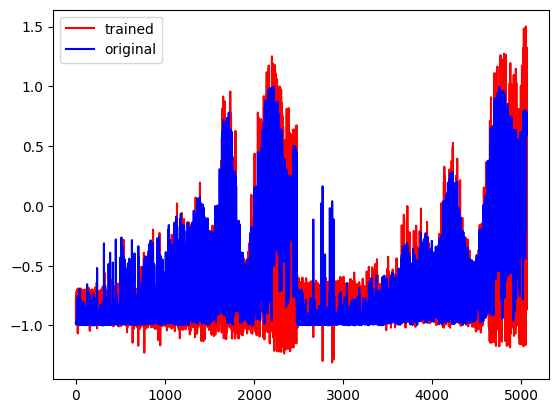

In [15]:
mountain_anfis.plotResults()

#### Fuzzy C Means

In [22]:
fuzzycmeans = FuzzCMeans(number_of_clusters=3,
                        fuzzines_parameter=2,
                        distance_metric='euclidean',
                        n_iter=1000,
                        verbose=False,)
fuzzycmeans.fit(train_embedding)

FuzzCMeans(number_of_clusters=3)

In [27]:
sigmas = fuzzycmeans.predict().std(axis=0).tolist()

# Get membership functions
fuzzy_membership_function = MemFuncs(get_fuzzy_membership_function(fuzzycmeans.centers_, sigmas))

# Instance anfis object and train it
fuzzy_anfis = ANFIS(train_embedding, train_modulus, fuzzy_membership_function)
fuzzy_x_pred = fuzzy_anfis.trainHybridJangOffLine(epochs=50)

current error: 415.3237141076476
current error: 399.25753973669316
current error: 398.6438673650714
current error: 398.0055368797074
current error: 397.2763702174391
current error: 396.4448882272435
current error: 395.49911983274524
current error: 394.4272654011304
current error: 393.2189236470912
current error: 391.8671475780659
current error: 390.37156200628647
current error: 388.7425804064588
current error: 387.0063349795763
current error: 385.2093290783207
current error: 383.42136893243867
current error: 381.7358526028727
current error: 380.269329742029
current error: 379.16888608922943
current error: 378.6483011450607
current error: 379.1008820740732
current error: 381.1230235539116
current error: 385.8448241676974
current error: 395.87056613882135
current error: 412.8319872814642
current error: 406.07626096757906
current error: 389.86232572602876
current error: 385.98135499601483
current error: 375.7311760528228
current error: 372.37948425437713
current error: 369.9902688075016
c

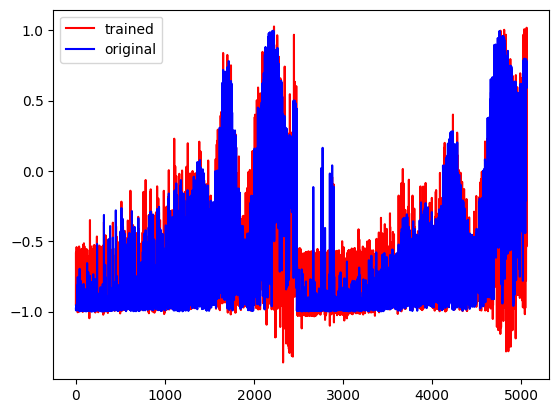

In [28]:
fuzzy_anfis.plotResults()